<a href="https://colab.research.google.com/github/toccht/CSCI-4962/blob/main/hw4/CSCI4962-HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSCI-4962 Homework 4
Author: Trevor Tocchet

# Task 1 (Recurrent Neural Networks)
Resources
* https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-recurrent-neural-networks

In [116]:
import numpy as np
import pandas as pd
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import SimpleRNN, LSTM, Dense, Dropout

In [117]:
WINDOW = 50
TICKER = 'KO'
TRUNCATED_DATA = 10000  # truncates beginning of data by 10,000 trading days

The data chosen for this problem is stock data and it can be solved via sequence models. It needs sequence models to solve this problem becuase stock data is time series data, meaning the data is indexing in time order. This is where RNN models can help by passing prior information to future steps. The data is clean but some preprocessing like normalization, training/testing split, and data sequencing needs to be done.

The data is from Yahoo Finance https://finance.yahoo.com/quote/KO?p=KO

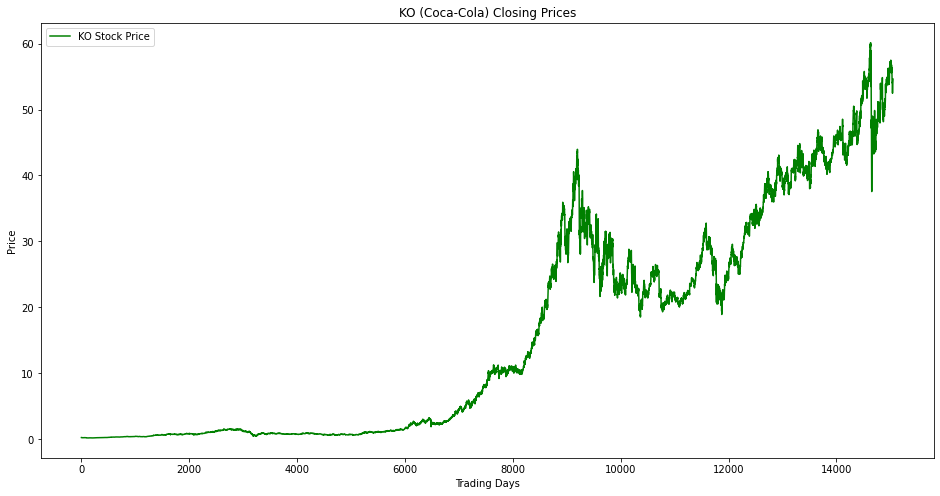

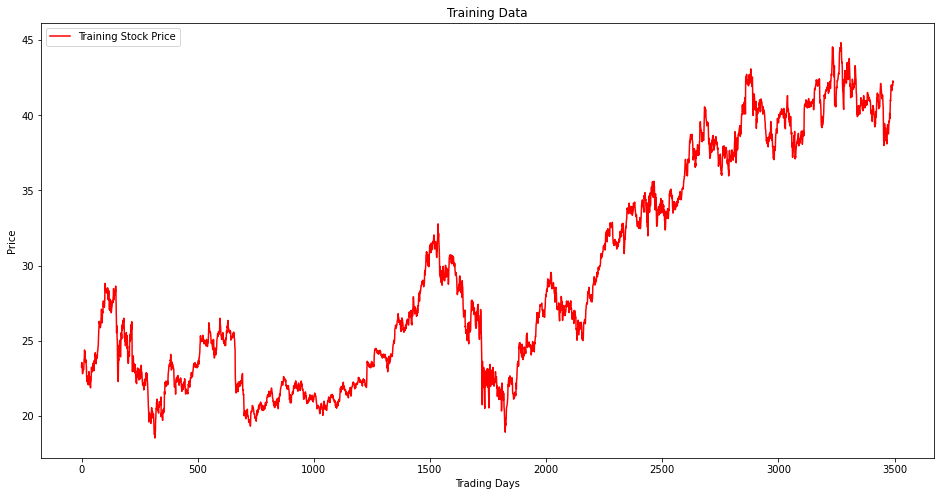

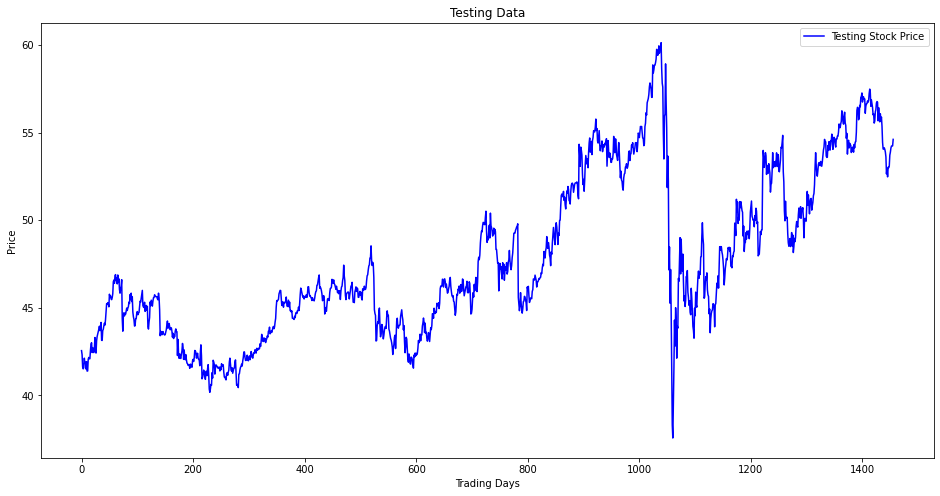

In [119]:
def data_sequencing(df):
  x = []
  y = []
  for i in range(WINDOW, df.shape[0]):
      x.append(df[i-WINDOW:i, 0])
      y.append(df[i, 0])
  x = np.array(x)
  y = np.array(y)
  x = np.reshape(x, (x.shape[0], x.shape[1], 1))
  return x, y

df = pd.read_csv('KO.csv')
df = df['Close'].values

_, ax = plt.subplots(figsize=(16,8))
plt.title('KO (Coca-Cola) Closing Prices')
plt.xlabel('Trading Days')
plt.ylabel('Price')
ax.plot(df, color='green', label='KO Stock Price')
plt.legend()

# split data
training_data = np.array(df[TRUNCATED_DATA:int(df.shape[0]*0.90)])
testing_data = np.array(df[int(df.shape[0]*0.90):])

# scale / normalize data
scaler = MinMaxScaler()
training_data = scaler.fit_transform(training_data.reshape(-1, 1))
testing_data = scaler.transform(testing_data.reshape(-1, 1))

# sequence data for input in RNN
x_train, y_train = data_sequencing(training_data)
x_test, y_test = data_sequencing(testing_data)

# graph training / testing data
y_training_scaled = scaler.inverse_transform(y_train.reshape(-1, 1))
_, ax = plt.subplots(figsize=(16,8))
plt.title('Training Data')
plt.xlabel('Trading Days')
plt.ylabel('Price')
ax.plot(y_training_scaled, color='red', label='Training Stock Price')
plt.legend()

y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))
_, ax = plt.subplots(figsize=(16,8))
plt.title('Testing Data')
plt.xlabel('Trading Days')
plt.ylabel('Price')
ax.plot(y_test_scaled, color='blue', label='Testing Stock Price')
plt.legend()

In [120]:
def build_simple_rnn_model():
  model = Sequential()
  model.add(SimpleRNN(units=128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
  model.add(Dropout(0.2))
  model.add(SimpleRNN(units=128, return_sequences=True))
  model.add(Dropout(0.2))
  model.add(SimpleRNN(128))
  model.add(Dropout(0.2))
  model.add(Dense(units=1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

def build_LTSM_model():
  model = Sequential()
  model.add(LSTM(units=128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
  model.add(Dropout(0.2))
  model.add(LSTM(units=128, return_sequences=True))
  model.add(Dropout(0.2))
  model.add(LSTM(128))
  model.add(Dropout(0.2))
  model.add(Dense(units=1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

In [ ]:
simple_rnn_model = build_simple_rnn_model()
rnn_history = simple_rnn_model.fit(x_train, y_train, epochs=20, batch_size=32)

ltsm_model = build_LTSM_model()
ltsm_history = ltsm_model.fit(x_train, y_train, epochs=20, batch_size=32)

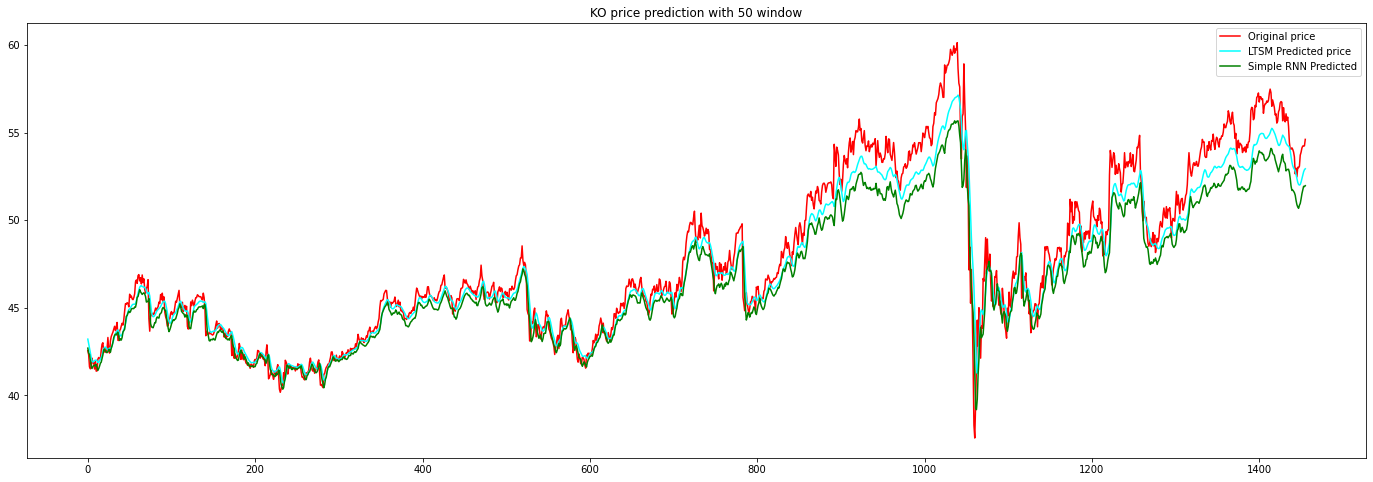

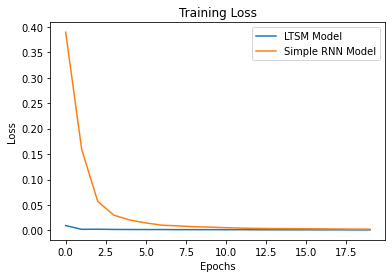

In [122]:
simple_rnn_predictions = simple_rnn_model.predict(x_test)
simple_rnn_predictions = scaler.inverse_transform(simple_rnn_predictions)

ltsm_predictions = ltsm_model.predict(x_test)
ltsm_predictions = scaler.inverse_transform(ltsm_predictions)

y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

_, ax = plt.subplots(figsize=(24,8))
ax.plot(y_test_scaled, color='red', label='Original price')
plt.plot(ltsm_predictions, color='cyan', label='LTSM Predicted price')
plt.plot(simple_rnn_predictions, color='green', label='Simple RNN Predicted')
plt.title('{} price prediction with {} window'.format(TICKER, WINDOW))
plt.legend()
plt.show()

plt.title('Training Loss')
plt.plot(ltsm_history.history['loss'], label='LTSM Model')
plt.plot(rnn_history.history['loss'], label='Simple RNN Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Model Decisions
For the number of layers and unit sizes within each layer, I used trial/error to decide those hyperparameters. As I increased the unit size, the model accuracy did better but was taking very long to train. The model did very poorly with small unit sizes, often leveling off during training (indicating information was not being passed through well to other layers). The activation function being used in both the Simple RNN and LTSM layers is tanh.

# Truncated training data
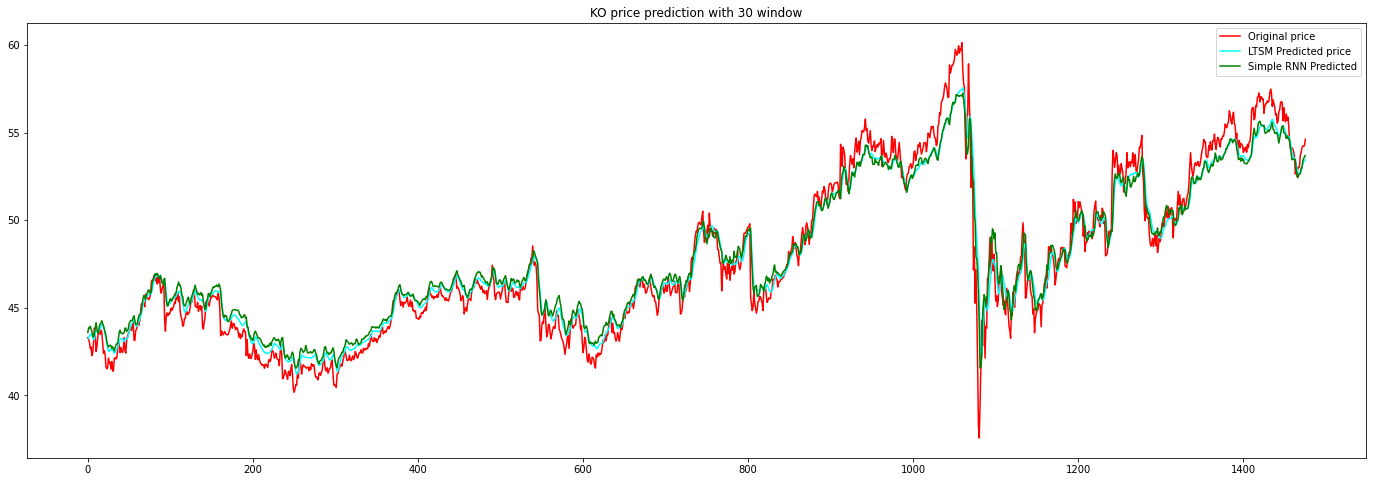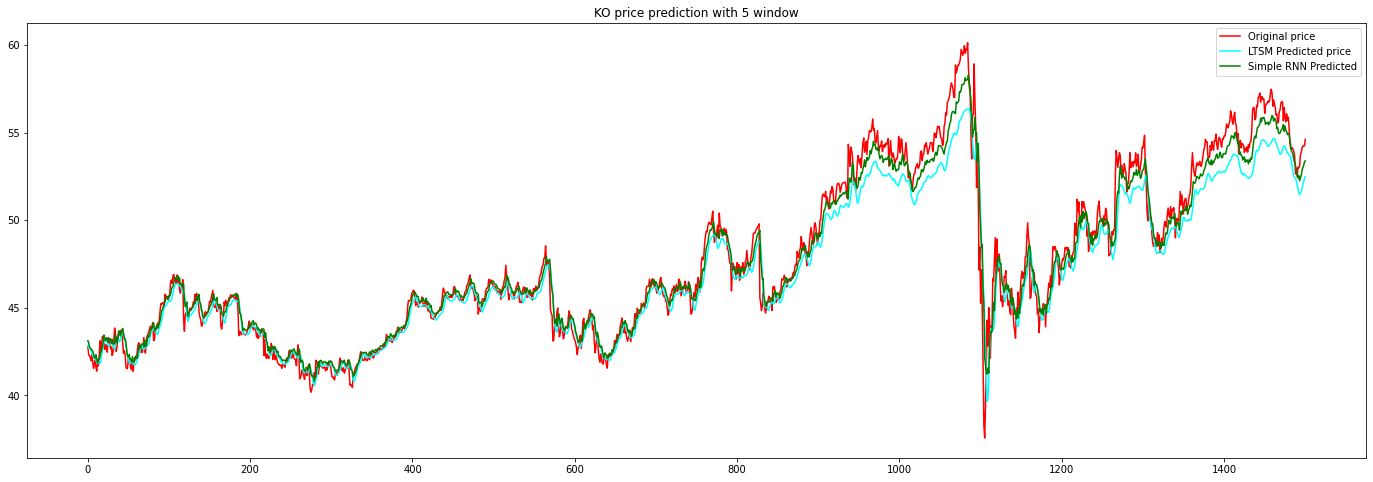

# Full Training Data
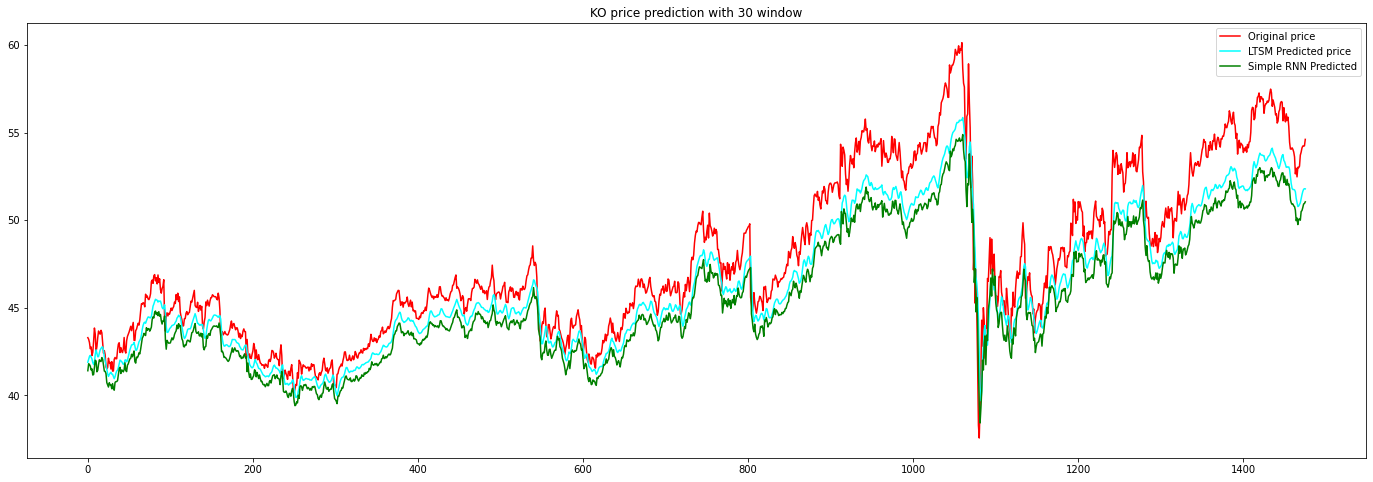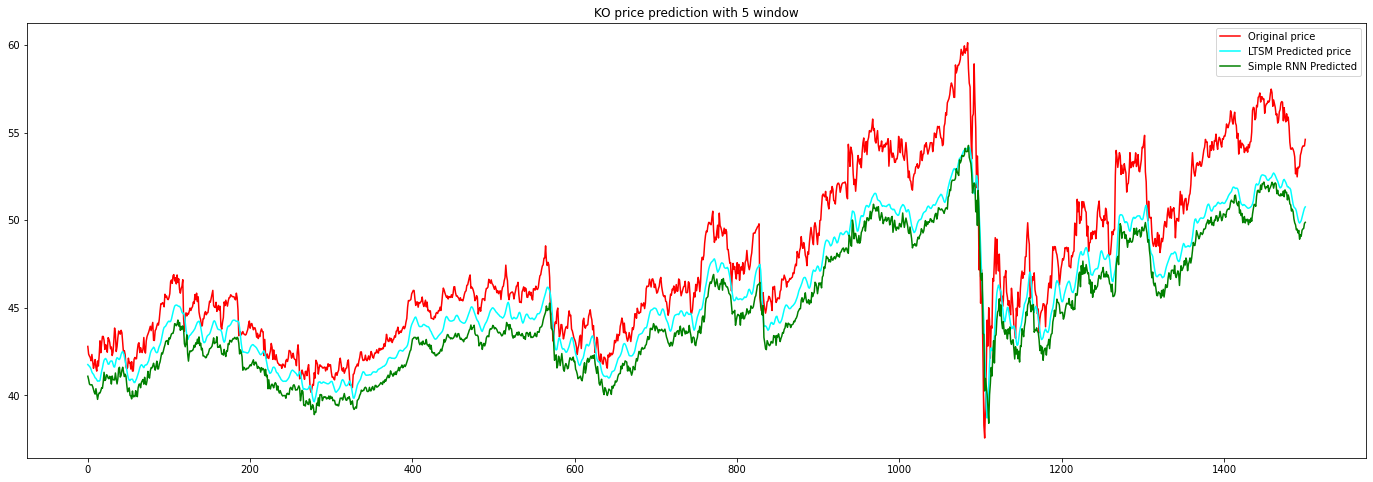

When using the truncated training set, vanilla RNN outperforms LTSM on the smaller window and almost identical on the long window. For this training data, I truncated the first 10,000 trading days because the price relative to the current price of the stock does not change very much.

When using the entire training set, Simple RNN performs quite well on the shorter window since the inherent nature of the vanilla RNN is they have a hard time carrying information from early steps to future ones. With a larger window (bigger sequence), the LTSM model out performs the vanilla RNN. Performance can be measured on how closely the prediction line matches up with the actual line on the graph.

I suspect this partly could be because much of the training data in the earlier steps are irrelevant when trying to predict the price of the testing set. LTSM retained much of that information so it therefore could do poorly trying to predict more recent prices. Window/sequence length plays a factor in the accuracy of a particular model.

# Task 2 (Word Embeddings)

In [123]:
import math
import torch
import torchtext

In [124]:
model = torchtext.vocab.GloVe(name="6B", dim=50) # trained on Wikipedia 2014 corpus

In [128]:
# user defined input
word1 = input('Word 1 input: ')
word2 = input('Word 2 input: ')

word1_vector = model[word1.strip()]
word2_vector = model[word2.strip()]

# Euclidean distance similarity measure
# distance = torch.norm(word1_vector - word2_vector)
distance = 0
for i in range(len(word1_vector)):
  distance += math.pow(word1_vector[i] - word2_vector[i], 2)
distance = math.sqrt(distance)
print('\nEuclidean Distance: {}'.format(distance))

# Cosine similarity measure
similarity = torch.cosine_similarity(word1_vector.unsqueeze(0),word2_vector.unsqueeze(0))
print('Cosine Similarity: {}'.format(float(similarity)))
print('1 - Cosine Similarity: {}'.format(1 - float(similarity)))


Word 1 input: boy
Word 2 input: girl

Euclidean Distance: 2.0426333155199754
Cosine Similarity: 0.9327199459075928
1 - Cosine Similarity: 0.06728005409240723


Euclidean distance can be used to measure how "close" word embeddings are to each other. On the other hand, cosine similarity is a measure of relative similarity rather than distance. In either case, the larger the number gets, the more likely the word embeddings are similar, it is the opposite case for the dissimilarity. 

Resources
* Cosine Similarity: https://arxiv.org/pdf/1910.09129.pdf
* Different Similarity/Dissimilarity Measures: https://towardsdatascience.com/17-types-of-similarity-and-dissimilarity-measures-used-in-data-science-3eb914d2681
* https://biblio.ugent.be/publication/7025226/file/7025291.pdf